In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression, LassoCV, Lasso, Ridge, RidgeCV, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import lilliefors
from scipy import stats

SEED = 23

In [2]:
def normality_tests(data):
    """
    Perform various statistical tests to assess the normality of a given dataset.

    This function conducts the following normality tests on the provided data:
    1. Shapiro-Wilk Test
    2. Kolmogorov-Smirnov Test
    3. Anderson-Darling Test
    4. Lilliefors Test
    5. D’Agostino’s K-squared Test

    Each test provides different insights into the normality of the distribution 
    of the dataset. The function prints the test statistic and p-value for each test.

    Parameters:
    data (array-like): A sequence of numerical data points. The data should be a 1D array-like 
                       structure (e.g., Python list, NumPy array, or Pandas Series).

    Returns:
    None: This function only prints the results of the normality tests to the console.
    """
    
    # Shapiro-Wilk Test
    shapiro_stat, shapiro_p = stats.shapiro(data)
    print(f'Shapiro-Wilk Test: Statistic={shapiro_stat}, p-value={shapiro_p}')

    # Kolmogorov-Smirnov Test
    ks_stat, ks_p = stats.kstest((data - np.mean(data)) / np.std(data), 'norm')
    print(f'Kolmogorov-Smirnov Test: Statistic={ks_stat}, p-value={ks_p}')

    # Anderson-Darling Test
    anderson_result = stats.anderson(data, dist='norm')
    print(f'Anderson-Darling Test: Statistic={anderson_result.statistic}')
    for i in range(len(anderson_result.critical_values)):
        sl, cv = anderson_result.significance_level[i], anderson_result.critical_values[i]
        print(f'At a significance level of {sl}, the critical value is {cv}.')

    # Lilliefors Test
    lilliefors_stat, lilliefors_p = lilliefors(data)
    print(f'Lilliefors Test: Statistic={lilliefors_stat}, p-value={lilliefors_p}')

    # D’Agostino’s K-squared Test
    dagostino_stat, dagostino_p = stats.normaltest(data)
    print(f"D'Agostino's K-squared Test: Statistic={dagostino_stat}, p-value={dagostino_p}")

In [3]:
def Winsorization_Method(df_source, columns,  lower, upper):
    """
    Remove outliers from the given DataFrame based on the provided lower and upper percentiles.

    Parameters:
    -----------
    df_source : pandas.DataFrame
        The original DataFrame from which outliers will be removed.
    columns : list of str
        The names of the columns to consider for outlier removal.
    lower : float
        The lower percentile below which data points are considered as outliers.
    upper : float
        The upper percentile above which data points are considered as outliers.

    Returns:
    --------
    ratio : float
        The ratio of outliers in the original DataFrame, rounded to two decimal places.
    df_win : pandas.DataFrame
        A new DataFrame with the outliers removed.
    
    Example:
    --------
    >>> ratio, df_win = Winsorization_Method(df, ['A', 'B'], 10, 90)
    
    Notes:
    ------
    - The function makes a copy of the original DataFrame, so the original DataFrame remains unchanged.
    - Outliers are determined separately for each column and are not considered across multiple columns.

    """
    #Data preparation
    df = df_source.copy()
    df = df[columns]

    #Determining records with outliers
    outliers=[]
    
    for col in columns:
        q1 = np.percentile(df[col], lower)
        q2 = np.percentile(df[col], upper)
        
        for pos in range(len(df)):
            if df[col].iloc[pos]>q2 or df[col].iloc[pos]<q1:
                outliers.append(pos) 
                
    outliers = set(outliers)                   
    outliers = list(outliers)
    
    ratio= round(len(outliers)/len(df)*100, 2) #calculating the ratio of outliers in the original data                     
    df_win = df.drop(df.index[outliers]) 
    
    return ratio, df_win

In [4]:
def Standard_Outlier_Remover(df_source, num_cols, num_std=3): 
    """
    Remove outliers from specified numeric columns in a DataFrame.
    
    Parameters:
    -----------
    df_source : pandas DataFrame
        The original DataFrame from which to remove outliers.
    num_cols : list of str
        List of column names in df_source that are numeric and should be checked for outliers.
    num_std : int or float, optional
        The number of standard deviations to use for defining outliers. Default is 3.
        
    Returns:
    --------
    df_win : pandas DataFrame
        A new DataFrame with outliers removed.
    ratio : float
        The percentage of observations in the original DataFrame that were identified as outliers.
    outliers : list of int
        List of row indices in the original DataFrame that were identified as outliers.
    """
    
    df = df_source.copy()
    
    outliers = []
    
    for col in num_cols:
        mean = df[col].mean()
        std = df[col].std()
        tol = num_std * std
        upper = mean + tol
        lower = mean - tol
        
        # Using vectorized operations to find outliers
        outlier_mask = (df[col] > upper) | (df[col] < lower)
        outliers.extend(df.index[outlier_mask])
        
    # Remove duplicates
    outliers = list(set(outliers))
    
    # Calculate ratio of outliers
    ratio = round(len(outliers) / len(df) * 100, 2)
    
    # Drop outliers
    df_win = df.drop(index=outliers)
    
    return df_win, ratio, outliers

# Data import and basic analysis

In [44]:
# Load Boston housing dataset
housing = fetch_california_housing()
X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = pd.Series(housing.target)
df = pd.concat([X, y], axis=1).rename(columns={0:'Value'})

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   Value       20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [46]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Value
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


<AxesSubplot:xlabel='HouseAge', ylabel='Value'>

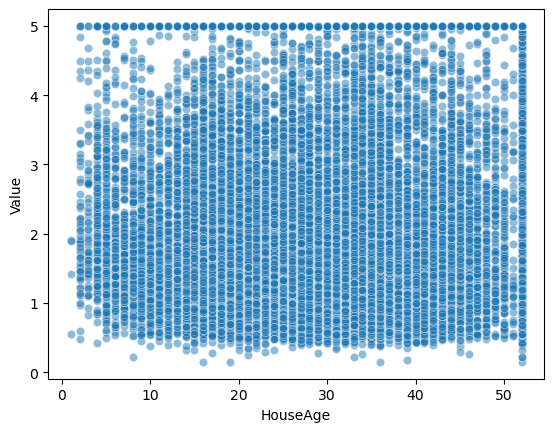

In [47]:
sns.scatterplot(data = df, x='HouseAge', y='Value',alpha = 0.5)

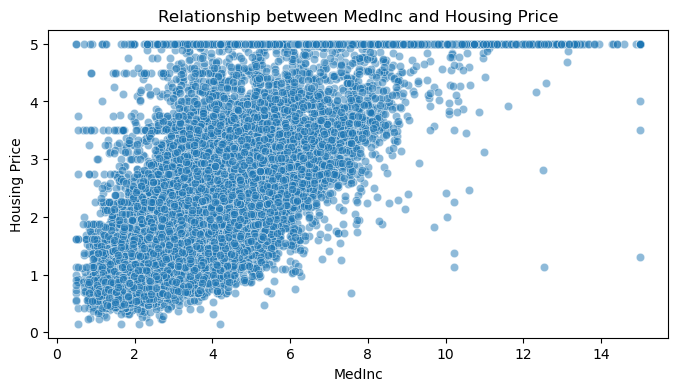

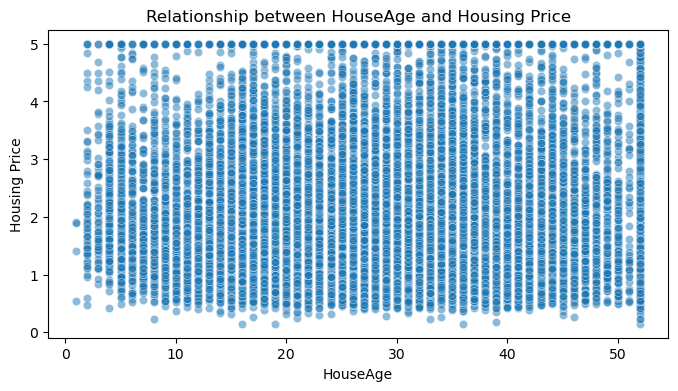

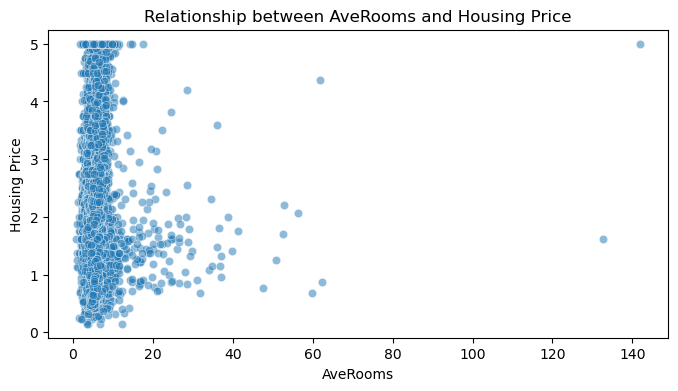

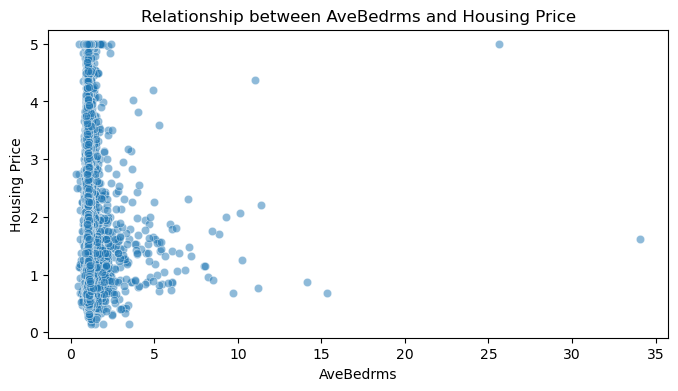

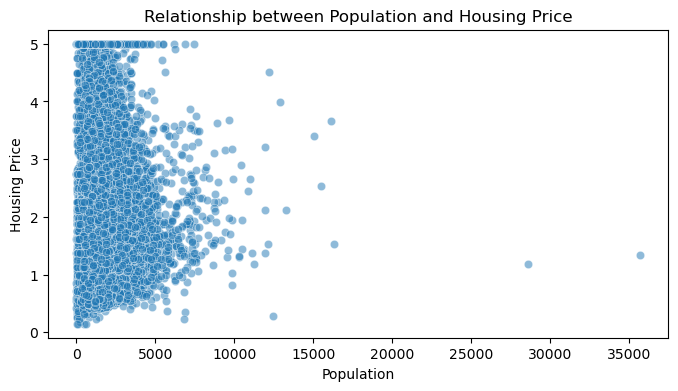

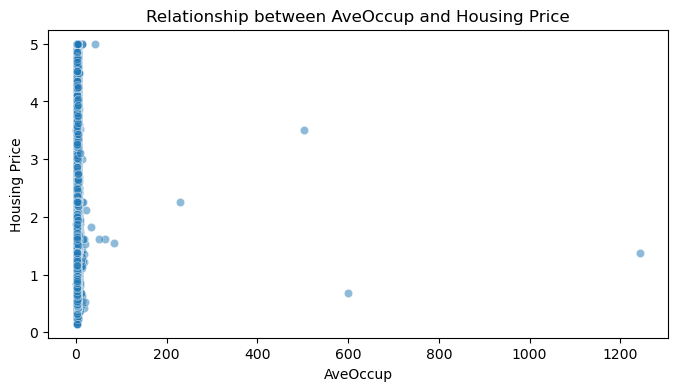

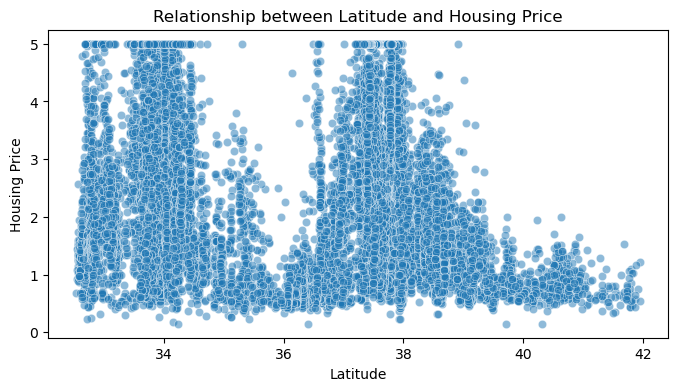

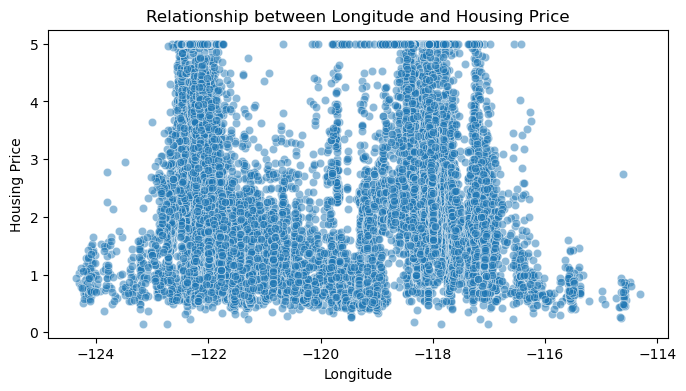

In [48]:
for column in X.columns:
    plt.figure(figsize=(8, 4))
    sns.scatterplot(data = df, x=column, y='Value',alpha = 0.5)
    plt.title(f'Relationship between {column} and Housing Price')
    plt.xlabel(column)
    plt.ylabel('Housing Price')
    plt.show()

In [49]:
df_std, ratio_std, outliers = Standard_Outlier_Remover(df, df.columns, 2)
print(f"Ratio of Outliers by Standard_Outlier_Remover:{ratio_std}")

Ratio of Outliers by Standard_Outlier_Remover:15.55


<AxesSubplot:>

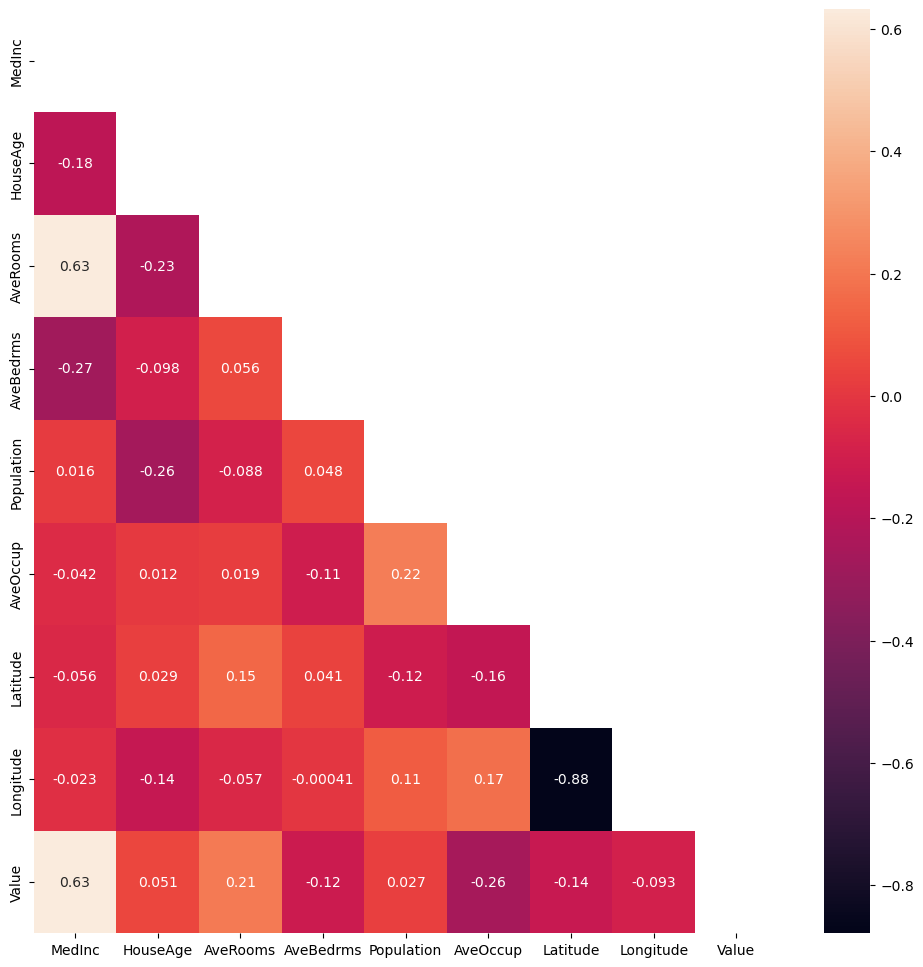

In [50]:
#calculating correlation matrix

corr = df_std.corr('spearman')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr, mask=mask, annot = True)

# Feature selection with Lasso and transformation

In [51]:
# Using LassoCV for feature selection
lasso = LassoCV(cv=5).fit(X, y)
print("Features selected by LassoCV:", list(X.columns[lasso.coef_ != 0]))

Features selected by LassoCV: ['MedInc', 'HouseAge', 'AveRooms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [52]:
X_train, X_test, y_train, y_test= train_test_split(df_std.drop(["Value", "Longitude", "AveBedrms"], axis=1),
                                                   df_std["Value"],test_size=0.1, shuffle = True, random_state=SEED)

In [53]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Linear Regression

In [54]:
regressor = LinearRegression()
regressor.fit(X_train_std, y_train)
y_pred = regressor.predict(X_test_std)
residuals = y_test - y_pred

In [55]:
scores = cross_val_score(regressor, X_train_std, y_train, cv=5, scoring='neg_mean_squared_error')
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("Average train MSE:", -np.mean(scores))
print("Test MAE:", mae)
print(f'Test mean Squared Error: {mse}')
print(f'Test coefficient of determination: {r2}')

Average train MSE: 0.3801972607362035
Test MAE: 0.47309991878971297
Test mean Squared Error: 0.37329980744034674
Test coefficient of determination: 0.5100089995113217


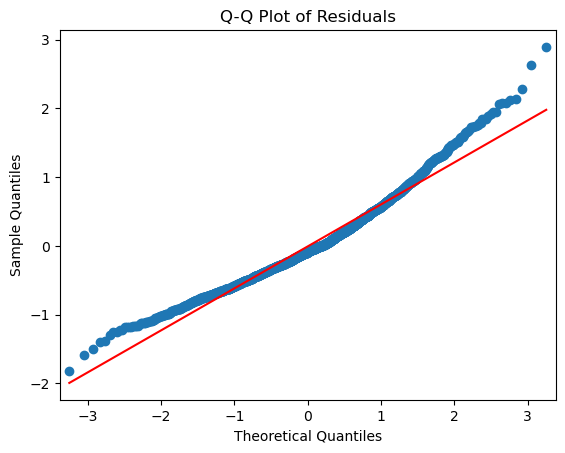

In [56]:
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

C:\Users\Pavilion\AppData\Local\Temp\ipykernel_22284\2665350104.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals)


<AxesSubplot:xlabel='Value', ylabel='Density'>

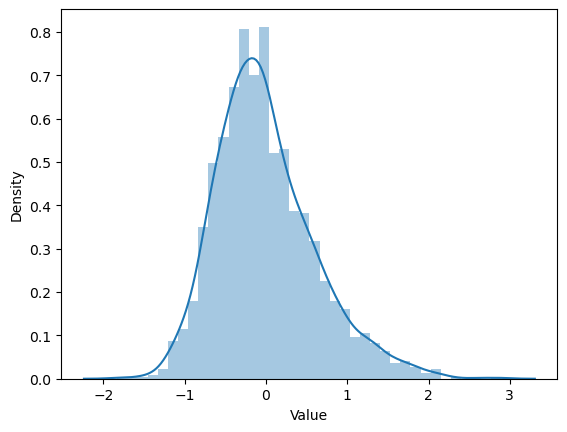

In [57]:
sns.distplot(residuals)

In [58]:
normality_tests(residuals)

Shapiro-Wilk Test: Statistic=0.9681519269943237, p-value=3.4772191409891624e-19
Kolmogorov-Smirnov Test: Statistic=0.07359175881890867, p-value=1.1666939362352822e-08
Anderson-Darling Test: Statistic=14.33500061946097
At a significance level of 15.0, the critical value is 0.575.
At a significance level of 10.0, the critical value is 0.655.
At a significance level of 5.0, the critical value is 0.785.
At a significance level of 2.5, the critical value is 0.916.
At a significance level of 1.0, the critical value is 1.09.
Lilliefors Test: Statistic=0.07359745204008816, p-value=0.0009999999999998899
D'Agostino's K-squared Test: Statistic=169.5072971344855, p-value=1.5558155436809053e-37


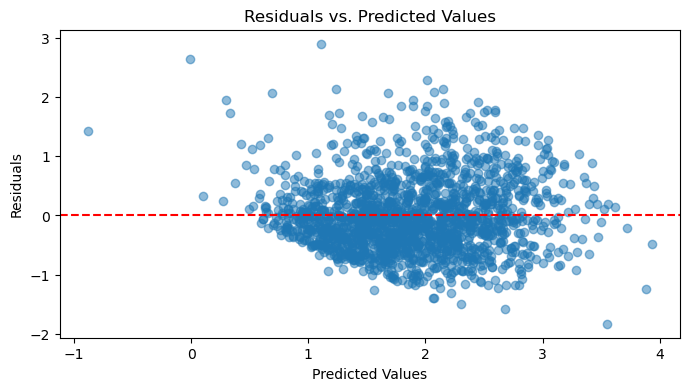

In [59]:
# Residuals vs Predicted values
plt.figure(figsize=(8, 4))
plt.scatter(y_pred, residuals, alpha = 0.5)
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [83]:
dw = durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw}')

Durbin-Watson statistic: 2.011164351524113


In [61]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

      feature         VIF
0      MedInc   11.511140
1    HouseAge    7.195917
2    AveRooms   45.993601
3   AveBedrms   43.590314
4  Population    2.935745
5    AveOccup    1.095243
6    Latitude  559.874071
7   Longitude  633.711654


In [103]:
standardized_coefficients = regressor.coef_
standardized_intercept = regressor.intercept_
original_coefficients = standardized_coefficients / scaler.scale_
original_intercept = standardized_intercept - np.dot(original_coefficients, scaler.mean_)

In [112]:
pd.DataFrame(data=original_coefficients, index=X_train.columns, columns=["Coefficient"])

,Coefficient
MedInc,0.485069
HouseAge,0.013768
AveRooms,-0.173579
Population,0.000079
AveOccup,-0.238526
Latitude,-0.032227


In [104]:
original_coefficients

array([ 4.85068721e-01,  1.37683697e-02, -1.73578633e-01,  7.91249200e-05,
       -2.38526263e-01, -3.22273775e-02])

# Elastic Net

In [62]:
param_grid = {
    'alpha': np.logspace(-4, 4, 10),  # For example: 10 numbers between 10^-4 and 10^4
    'l1_ratio': np.linspace(0.01, 1.0, 10)  # l1_ratio between 0.01 and 1
}


In [65]:
# Initialize a GridSearchCV object
grid = GridSearchCV(estimator=ElasticNet(max_iter=10000), param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid.fit(X, y)

print("Best parameters:", grid.best_params_)
print("Best score MSE:", -grid.best_score_) 

Best parameters: {'alpha': 0.005994842503189409, 'l1_ratio': 0.01}
Best score MSE: 0.5579835279370906


# Polynominal Regression

In [113]:
for i in range(1,7):
    # Create polynomial features
    poly_features = PolynomialFeatures(degree=i, include_bias=False)
    X_poly_train = poly_features.fit_transform(X_train_std)

    # Fit the model
    poly_reg_model = LinearRegression()
    poly_reg_model.fit(X_poly_train, y_train)

    # Predict on training data
    X_poly_test = poly_features.transform(X_test_std)
    y_pred = poly_reg_model.predict(X_poly_test)

    # Calculate and print the mean squared error
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean squared error {i}: {mse}")

Mean squared error 1: 0.37329980744034663
Mean squared error 2: 0.32916017581901963
Mean squared error 3: 0.30561136803139244
Mean squared error 4: 0.28258566444341354
Mean squared error 5: 0.2839813309942578
Mean squared error 6: 0.40355268315306797


In [92]:
# Create polynomial features
poly_features = PolynomialFeatures(degree=4, include_bias=True)
X_poly_train = poly_features.fit_transform(X_train_std)

# Fit the model
poly_reg_model = LinearRegression()
poly_reg_model.fit(X_poly_train, y_train)

# Predict on training data
X_poly_test = poly_features.transform(X_test_std)
y_pred = poly_reg_model.predict(X_poly_test)

# Calculate and print the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {mse}")

Mean squared error: 0.28258566444342537
